### A dirty little trick to avoid dealing with paths. 

In [1]:
import os
os.chdir('/home/juagudelo/HOMEdev/drought_pred_hybrid/')

In [2]:
os.getcwd()

'/home/juagudelo/HOMEdev/drought_pred_hybrid'

## From here, this notebook is going to be used to evaluate the best model issued from the hyperparameter tuning over the test set.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import models
import utilities

In [17]:
# Fixing a seed to warrant the reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [18]:
# Initializing the model
batch_size=128
output_weeks=6
# Hyperparameters
hidden_size= 512
num_lstm_layers= 2
num_fc_tabular_layers= 2
num_fc_combined_layers= 4
dropout= 0.3

ablation_TS=False
ablation_tabular=False
ablation_attention=False

In [19]:
X_tabular_test = np.load("data/processed_no_cat_and_no_tensors/X_tabular_test.npy")
X_time_test = np.load("data/processed_no_cat_and_no_tensors/X_time_test.npy")
y_target_test = np.load("data/processed_no_cat_and_no_tensors/y_target_test.npy")
X_tabular_valid = np.load("data/processed_no_cat_and_no_tensors/X_tabular_validation.npy")
X_time_valid = np.load("data/processed_no_cat_and_no_tensors/X_time_valid.npy")
y_target_valid = np.load("data/processed_no_cat_and_no_tensors/y_target_valid.npy")
with open(f"data/processed_no_cat_and_no_tensors/valid_fips.pickle", "rb") as f:
    valid_fips = pickle.load(f)
with open(f"data/processed_no_cat_and_no_tensors/test_fips.pickle", "rb") as f:
    test_fips = pickle.load(f)

In [20]:
valid_data = TensorDataset(
    torch.tensor(X_time_valid).type(torch.FloatTensor),
    torch.tensor(X_tabular_valid).type(torch.FloatTensor),
    torch.tensor(y_target_valid[:, :output_weeks]).type(torch.FloatTensor),
)

test_data = TensorDataset(
    torch.tensor(X_time_test).type(torch.FloatTensor),
    torch.tensor(X_tabular_test).type(torch.FloatTensor),
    torch.tensor(y_target_test[:, :output_weeks]).type(torch.FloatTensor),
)

# DataLoaders with sampler for training and default for validation

valid_loader = DataLoader(
    valid_data, shuffle=False, batch_size=batch_size, drop_last=False
)

test_loader = DataLoader(
    test_data, shuffle=False, batch_size=batch_size, drop_last=False
)

In [21]:
test = iter(valid_loader)
X_time, X_static, y_target = next(test)

In [22]:
# set up the device
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = models.HybridModel_custom(num_numerical_features=X_tabular_valid.shape[-1],
                                  num_time_series_features=X_time_valid.shape[-1],
                                  hidden_size=hidden_size,
                                  num_lstm_layers=num_lstm_layers,
                                  dropout=dropout,
                                  num_fc_tabular_layers=num_fc_tabular_layers,
                                  num_fc_combined_layers=num_fc_combined_layers,
                                  output_size=output_weeks,
                                  ablation_TS=ablation_TS,
                                  ablation_tabular=ablation_tabular,
                                  ablation_attention=ablation_attention,)

model.load_state_dict(torch.load("models/MH_Hybrid_Scratch_1Loss/MH_Hybrid_Scratch_1Loss_oneLoss.pt", weights_only=True))
# model.load_state_dict(torch.load("models/MH_Hybrid_Ablation/MH_Hybrid_Ablation_entire.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


HybridModel_custom(
  (tabular_fc_layers): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (lstm): LSTM(21, 512, num_layers=2, batch_first=True, dropout=0.3)
  (attention): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_after_context): Linear(in_features=512, out_features=64, bias=True)
  (combined_fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_fea

In [23]:
def predict(x, static):
    out = model(x, static)
    return out

In [24]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    # "fips": [],
    # "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for  x, static, y in tqdm(
    test_loader,
    desc="Test predictions...",
):
    x, static, y = x.to(device), static.to(device), y.to(device)
    with torch.no_grad():
        pred = predict(x, static).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

Test predictions...: 100%|██████████| 69/69 [00:17<00:00,  3.98it/s]


In [25]:
df

,y_pred,y_pred_rounded,y_true,week
0,1.925153,2,2.8891,0
1,0.404948,0,0.8519,0
2,0.067383,0,0.0000,0
3,1.588632,2,1.4617,0
4,1.230978,1,1.6942,0
...,...,...,...,...
52603,0.922171,1,0.0000,5
52604,1.737472,2,2.0000,5
52605,0.176093,0,0.0000,5
52606,0.194181,0,0.0000,5


In [26]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred_rounded'], average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

Week 1 MAE 0.143 F1 0.752
Week 2 MAE 0.198 F1 0.661
Week 3 MAE 0.252 F1 0.588
Week 4 MAE 0.307 F1 0.513
Week 5 MAE 0.352 F1 0.445
Week 6 MAE 0.395 F1 0.413


(array([5.0000e+00, 6.0000e+00, 6.0000e+00, 1.3000e+01, 9.0000e+00,
        2.6000e+01, 3.4000e+01, 6.3000e+01, 9.6000e+01, 1.0700e+02,
        2.1300e+02, 2.1700e+02, 3.8500e+02, 5.5800e+02, 6.8000e+02,
        1.1210e+03, 2.3940e+03, 7.5730e+03, 2.7076e+04, 2.4840e+03,
        2.0730e+03, 1.7770e+03, 1.4940e+03, 1.5540e+03, 1.0320e+03,
        4.4300e+02, 2.9200e+02, 2.7400e+02, 2.3300e+02, 1.7900e+02,
        6.9000e+01, 4.4000e+01, 2.0000e+01, 2.5000e+01, 1.4000e+01,
        1.0000e+01, 5.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-3.22419906, -3.05305956, -2.88192006, -2.71078056, -2.53964106,
        -2.36850156, -2.19736206, -2.02622256, -1.85508306, -1.68394356,
        -1.51280406, -1.34166456, -1.17052506, -0.99938556, -0.82824606,
        -0.65710656, -0.48596706, -0.31482756, -0.14368806,  0.02745143,
         0.19859093,  0.36973043,  0.54086993,  0.71200943,  0.88314893,
         1.05428843,  1.22542793,  1.39656743,  1.56770693,  1.73884643,
         1.90998

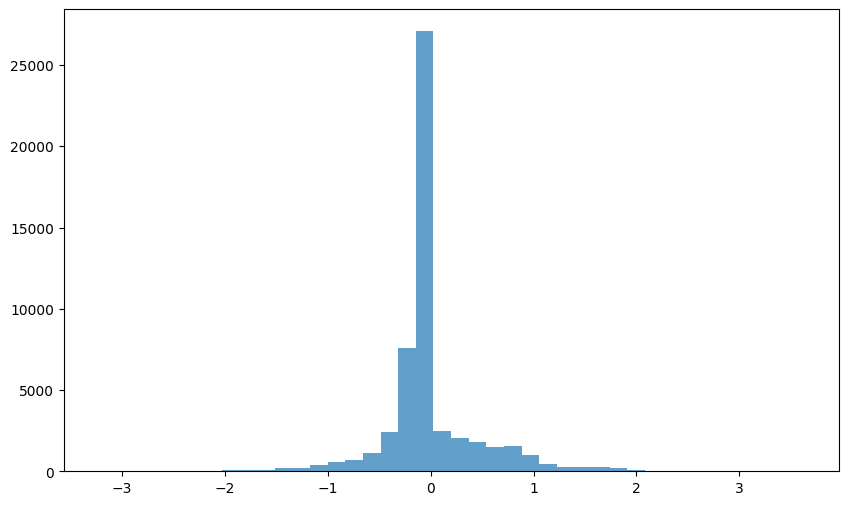

In [27]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist((df['y_true'] - df['y_pred']), bins=40, alpha=0.7, label='error')

# The next section evaluates the ablation study

<Axes: >

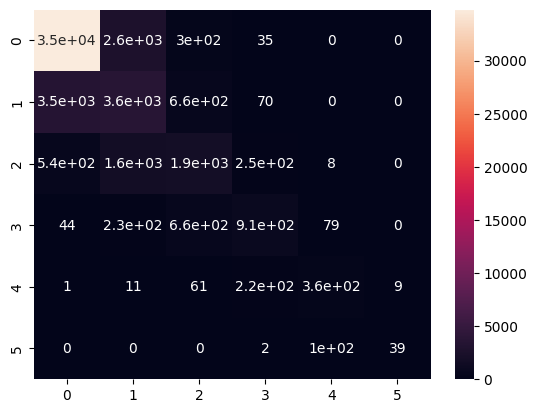

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, root_mean_squared_error
import seaborn
seaborn.heatmap(confusion_matrix(df['y_true'].round(), df['y_pred'].round()), annot=True)

In [29]:
# setting data to calculate the ROC AUC
def calculate_metrics(model_name, model_path):

    device=torch.device("cpu")
    print(f"Using device: {device}")
    print(torch.cuda.get_device_name(device=None))

    model = models.HybridModel(num_categorical_features,
                            list_cat,
                            num_numerical_features,
                            num_time_series_features,
                            hidden_size,
                            num_lstm_layers,
                            dropout,
                            embedding_dims,
                            num_fc_tabular_layers,
                            num_fc_combined_layers,
                            output_size=output_weeks,
    )

    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.to(device)

    dict_map = {
        "y_pred": [],
        "y_pred_rounded": [],
        "y_true": [],
        "week": [],
    }
    i = 0
    for static, static_cat, x, y in tqdm(
        test_loader,
        desc="Test predictions...",
    ):
        x, static, y = x.to(device), static.to(device), y.to(device)
        with torch.no_grad():
            pred = predict(x, static, static_cat).clone().detach()
        for w in range(output_weeks):
            dict_map["y_pred"] += [float(p[w]) for p in pred]
            dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
            # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
            # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
            dict_map["y_true"] += [float(item[w]) for item in y]
            dict_map["week"] += [w] * len(x)
        i += len(x)
    df = pd.DataFrame(dict_map)

    # for w in range(6):
    #     wdf = df[df['week']==w]
    #     mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    #     f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    #     print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

    y_true_roc = df['y_true'].round()
    y_pred_roc = df['y_pred'].round()
    y_pred_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_pred_roc])
    for i in range(len(y_pred_roc)):
        y_pred_for_sklearn[i, int(y_pred_roc[i])] = 1

    y_true_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_true_roc])
    for i in range(len(y_true_roc)):
        y_true_for_sklearn[i, int(y_true_roc[i])] = 1

    mae = mean_absolute_error(df['y_true'], df['y_pred'])
    rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
    f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
    roc_auc = roc_auc_score(y_true_for_sklearn, y_pred_for_sklearn, multi_class='ovr', average='weighted')
    
    results = pd.DataFrame({'Model': [model_name], 'MAE': [mae], 'RMSE': [rmse], 'F1': [f1], 'ROC_AUC': [roc_auc]})

    return results

In [30]:
ablation_study_schema = [("static", "models/MH_Hyper/MH_Hyper_12.pt"),
                         ("ts_no_att", ""),
                         ("ts", ""),
                         ("static_ts_no_att", ""),
                         ("entire", ""),
                         ]

In [31]:
results_df = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'F1', 'ROC_AUC'])

for name, path in ablation_study_schema:
    # Fixing a seed to warrant the reproducibility
    torch.manual_seed(21)
    np.random.seed(21)
    results_df = pd.concat([results_df, calculate_metrics(name, path)])

Using device: cpu
NVIDIA T1000 8GB


NameError: name 'num_categorical_features' is not defined

In [17]:
results_df

,Model,MAE,RMSE,F1,ROC_AUC
0,static,0.259596,0.470429,0.589339,0.785717
0,ts_no_att,0.259596,0.470429,0.589339,0.785717
